# Edinburgh Airbnb Data Preparation

This notebook handles the loading, exploration, cleaning, and preparation of the Airbnb Listing Data.
## 1. Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

## 2. Load Airbnb Data

In [2]:
# Read in csv file
edinburgh_airbnb = pd.read_csv('../../data/edinburgh/edinburgh_listings.csv')

# Read in glx town boundaries for Edinburgh
edinburgh_glx = gpd.read_file('../../data/edinburgh/edinburgh_seamless.gpkg')

In [3]:
# Print the column names of the Edinburgh Airbnb data
edinburgh_airbnb.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [4]:
# Keep only relevant columns
edinburgh_airbnb = edinburgh_airbnb[["id", "listing_url", "name", "neighbourhood", "neighbourhood_cleansed", "neighbourhood_group_cleansed", "accommodates", "availability_eoy", "estimated_occupancy_l365d", "price", "estimated_revenue_l365d", "longitude", "latitude"]]

In [5]:
# Convert to GeoDataFrame
edinburgh_airbnb = gpd.GeoDataFrame(
    edinburgh_airbnb,
    geometry = gpd.points_from_xy(edinburgh_airbnb['longitude'], edinburgh_airbnb['latitude']),
    crs = 'EPSG:4326'
)

## 3. Exploration and Cleaning

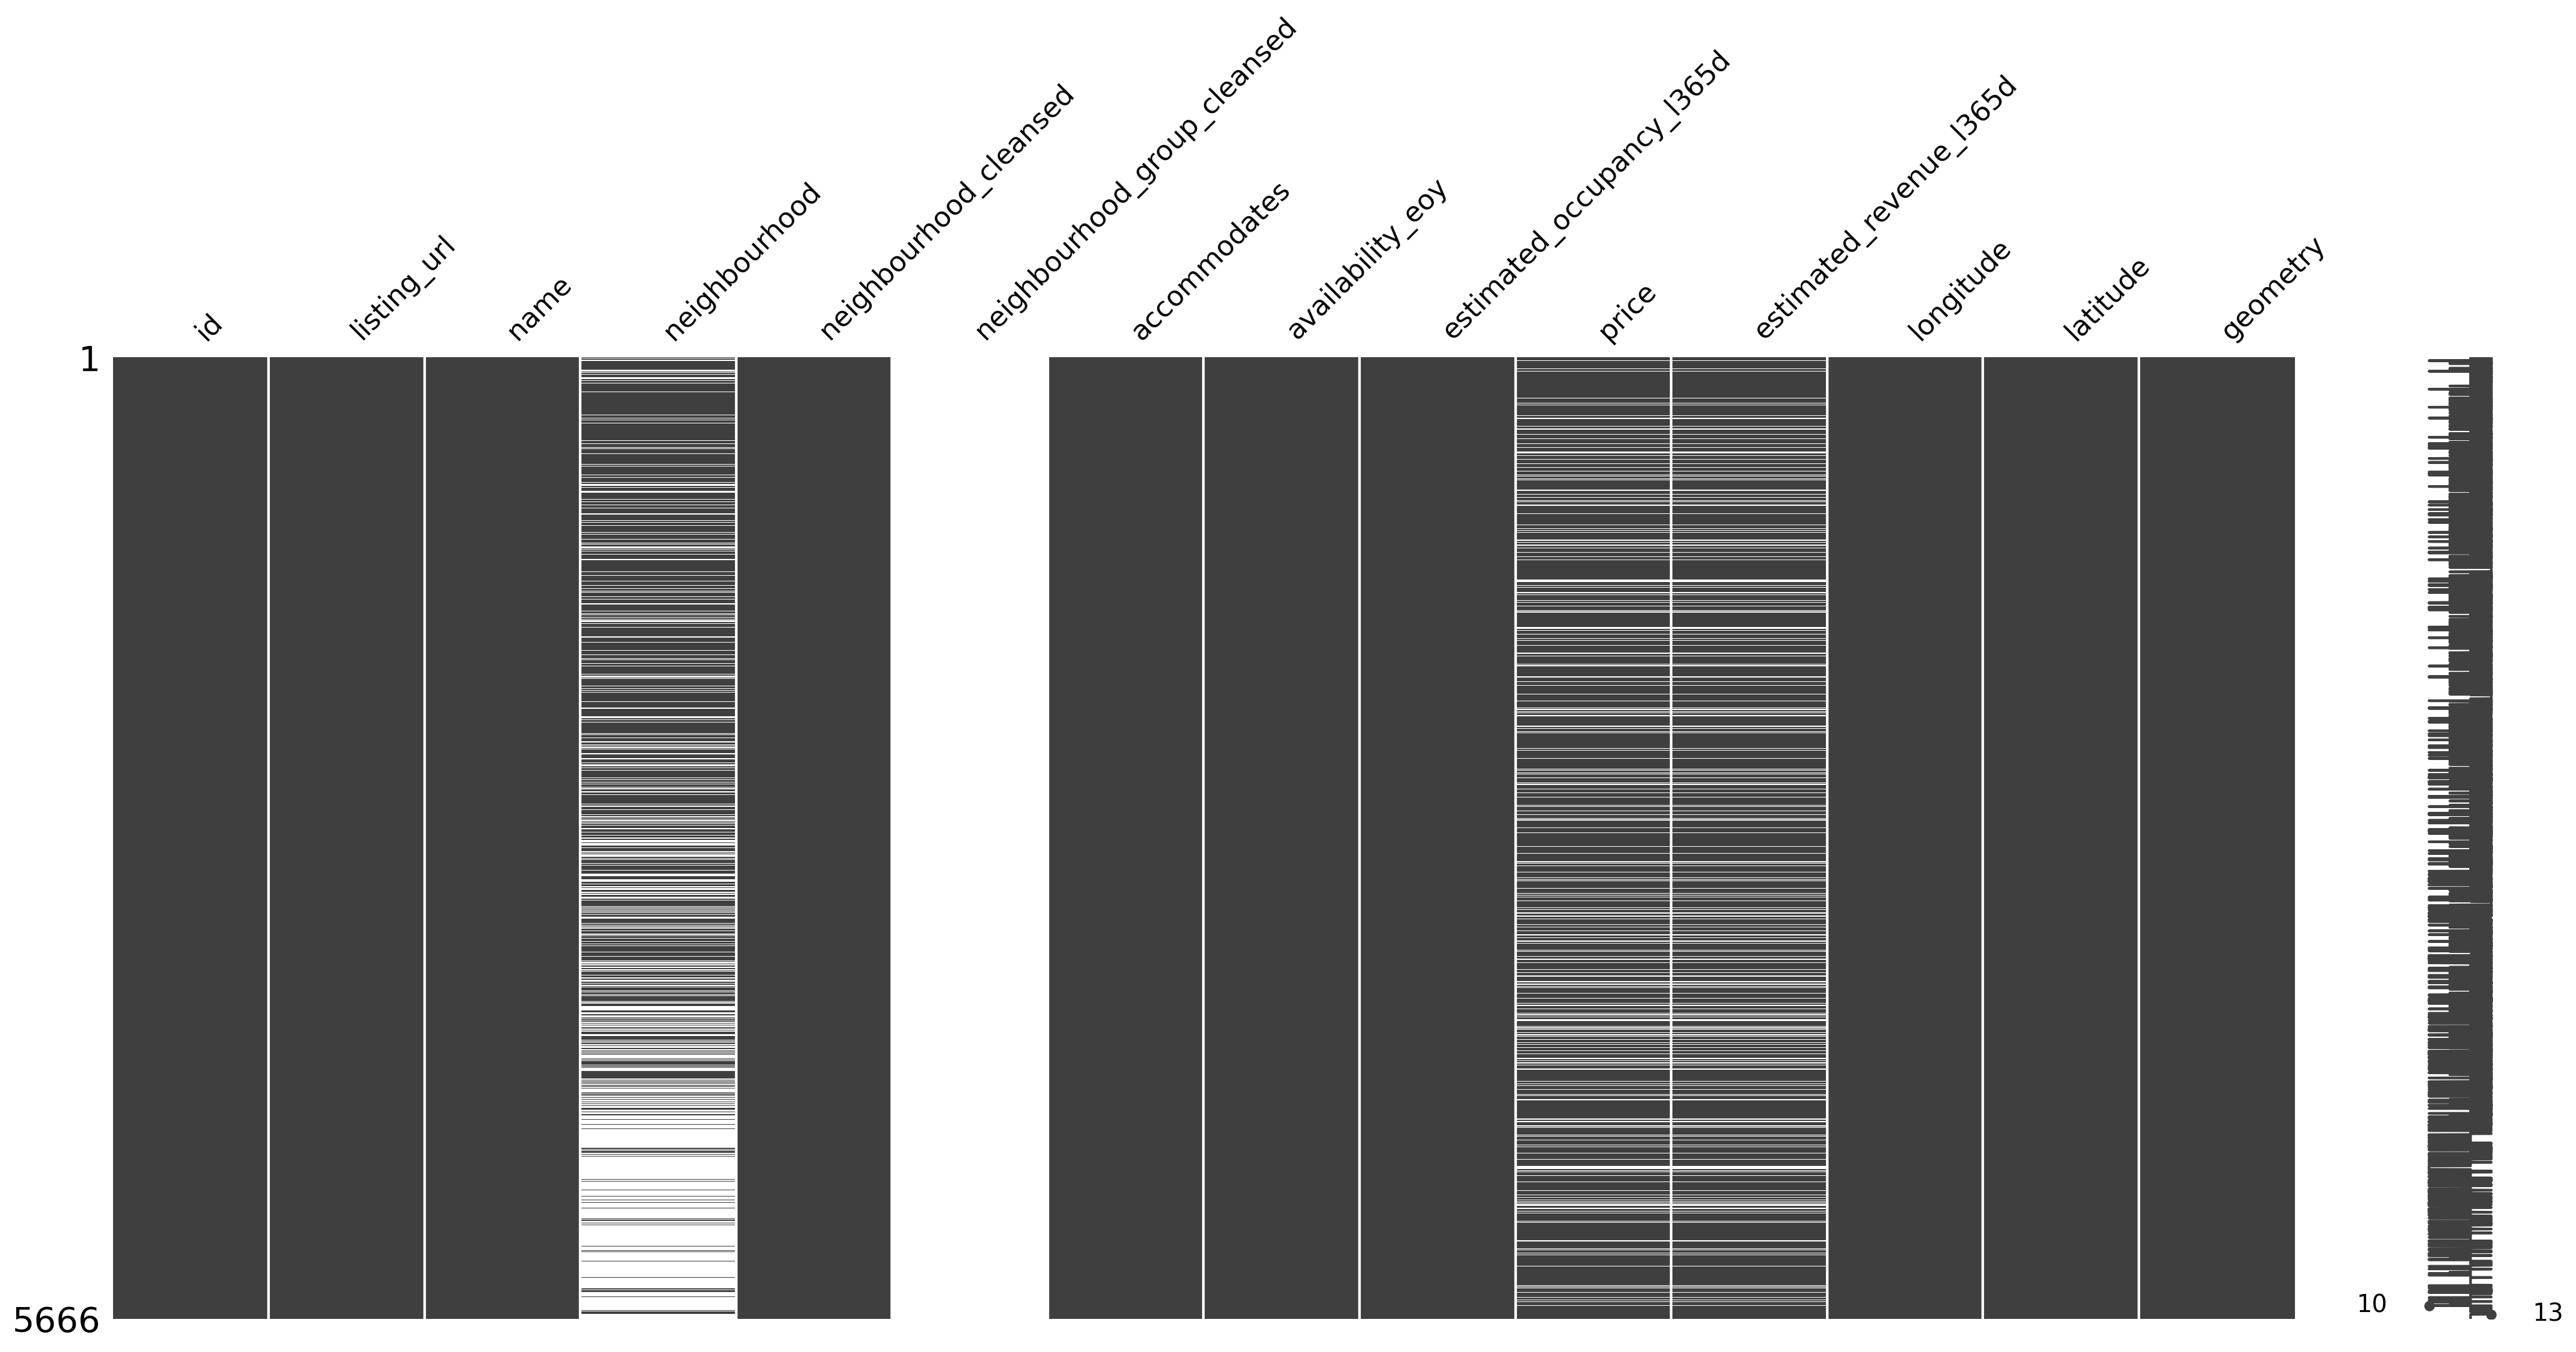

In [6]:
# Check for missing values
msno.matrix(edinburgh_airbnb);

In [7]:
# Remove properties where 'price' is NA
edinburgh_airbnb = edinburgh_airbnb.dropna(subset=['price'])

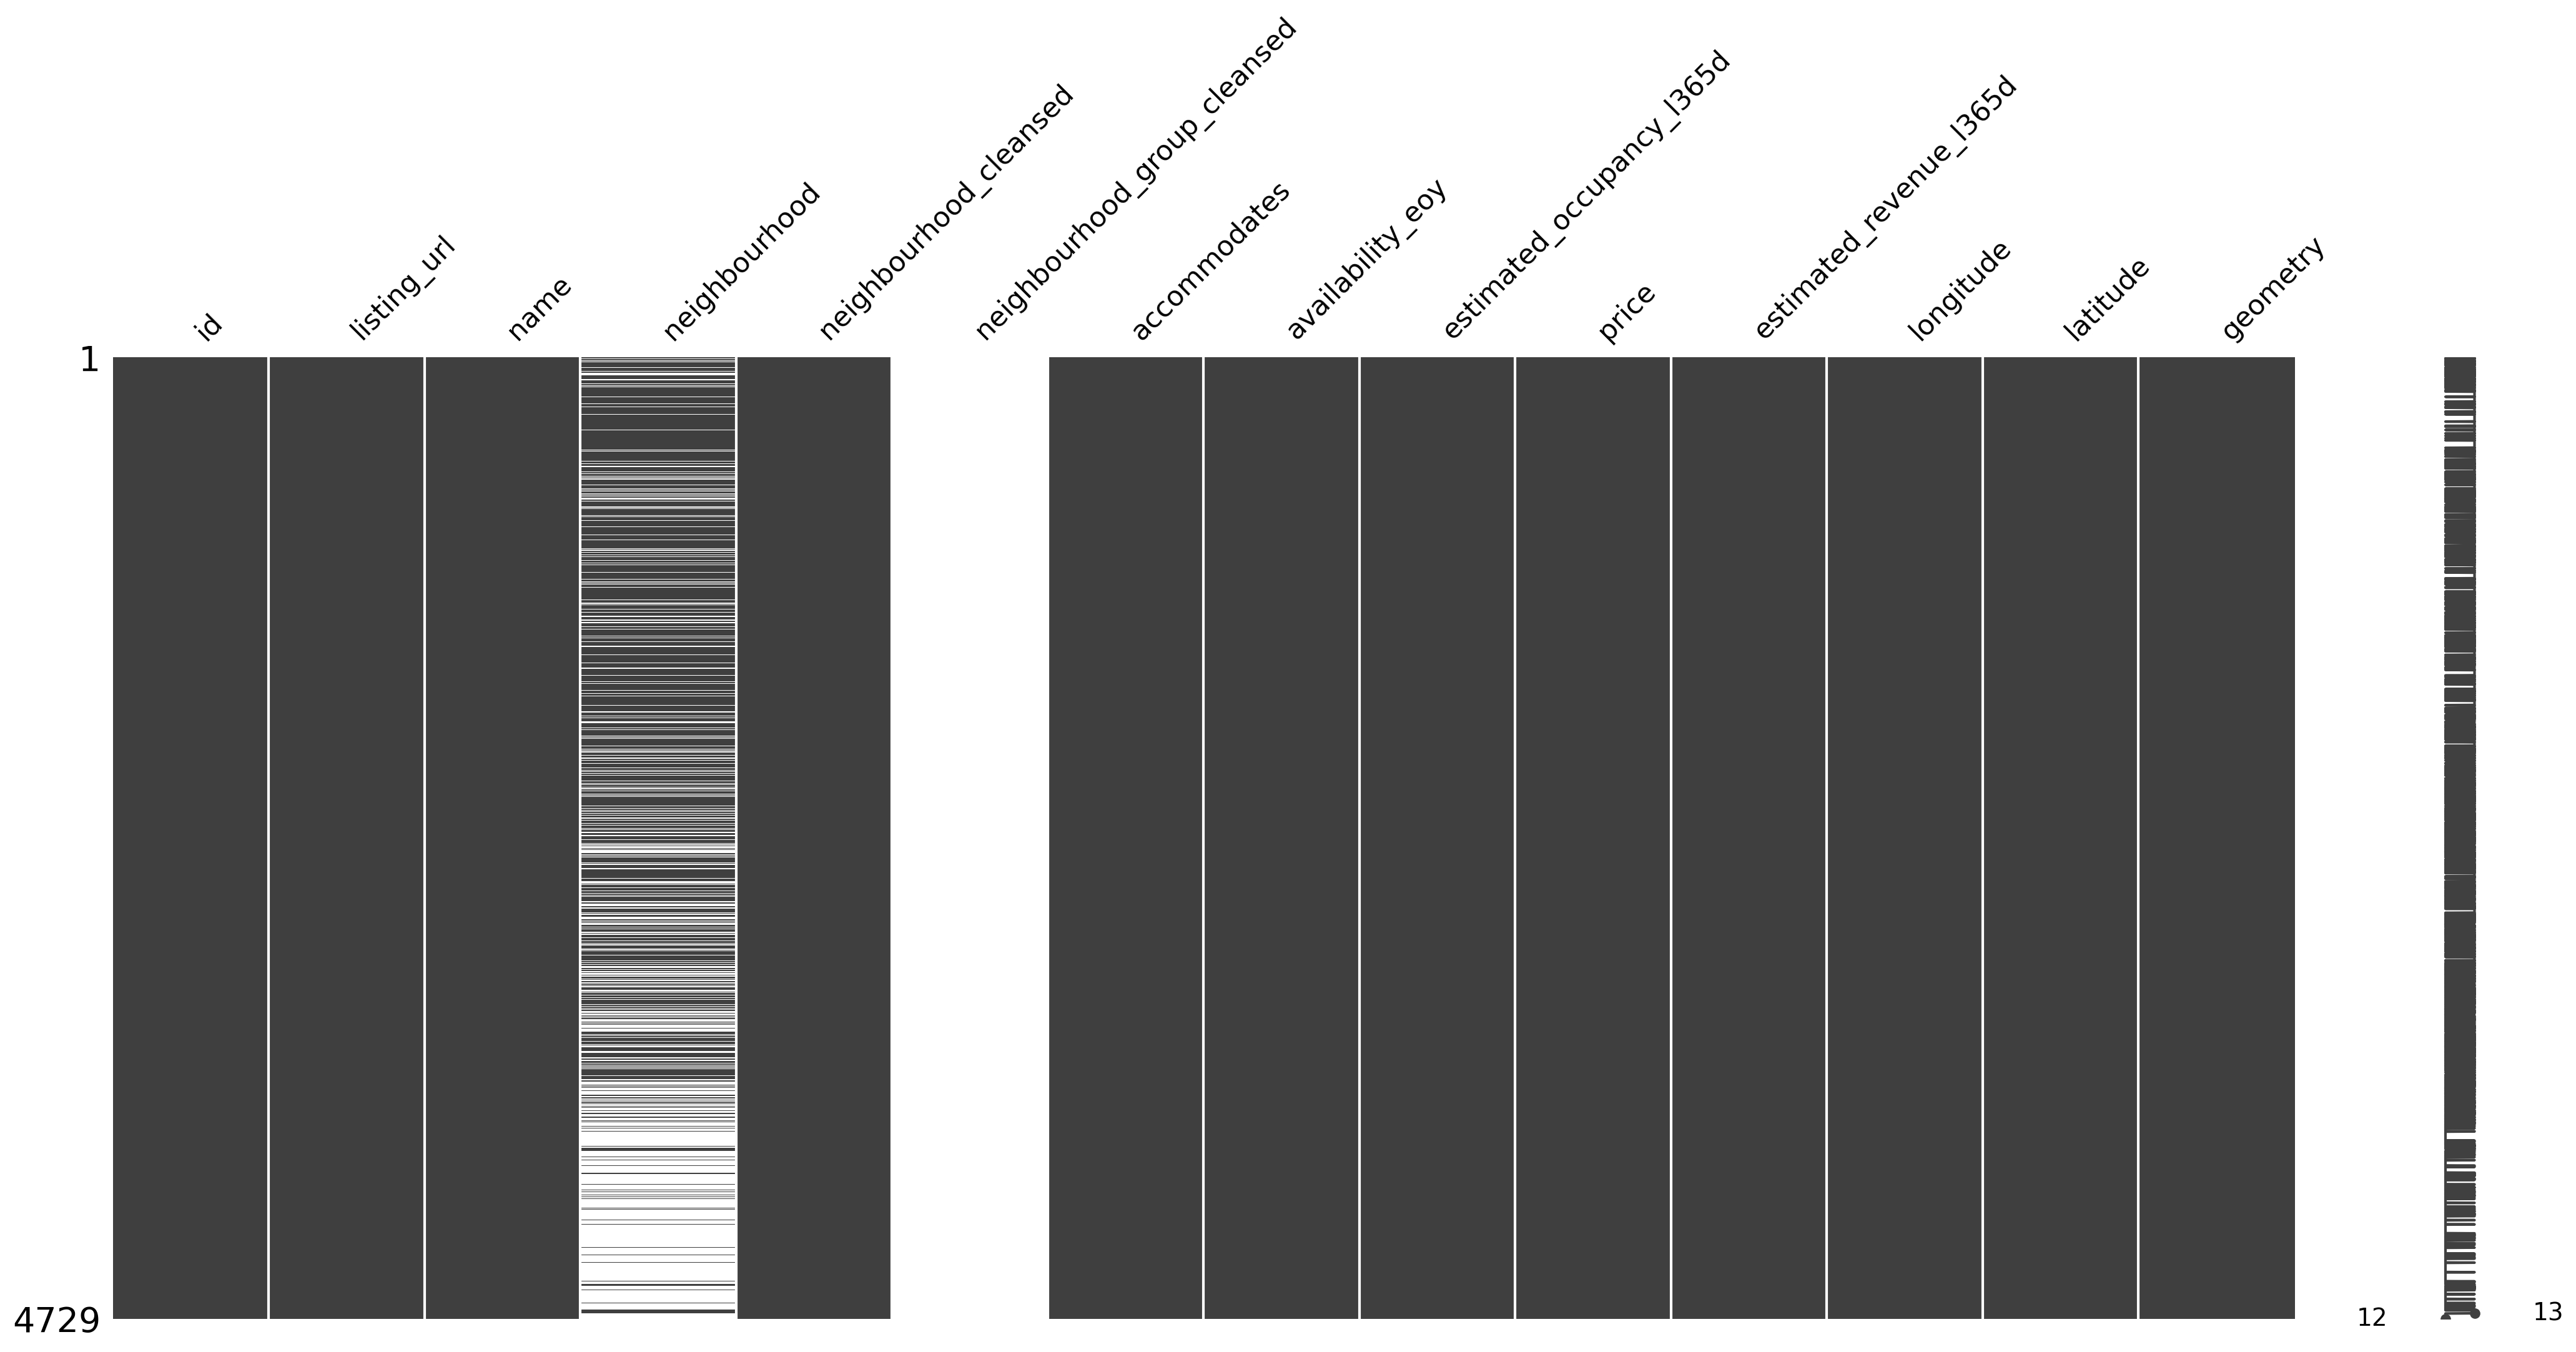

In [8]:
msno.matrix(edinburgh_airbnb);

A total of 937 (16%) have been dropped.

In [9]:
# Remove currency symbols and commas, then convert to float
edinburgh_airbnb['price'] = (
    edinburgh_airbnb['price']
    .replace('[\\$,]', '', regex=True)  # Remove $ and , characters
    .astype(float)
)

In [10]:
# Drop listings with zero price
edinburgh_airbnb = edinburgh_airbnb[edinburgh_airbnb['price'] > 0]
# Drop listings with zero estimated_occupancy
edinburgh_airbnb = edinburgh_airbnb[edinburgh_airbnb['estimated_occupancy_l365d'] > 0]
# Drop listings with zero accommodates
edinburgh_airbnb = edinburgh_airbnb[edinburgh_airbnb['accommodates'] > 0]

In [11]:
# Find total number of properties in the dataset
total_properties = len(edinburgh_airbnb)
print(f'Total number of properties: {total_properties}')

Total number of properties: 4123


After cleaning, a total of 1,543 (27%) listings have been dropped.

In [12]:
# Rename the id column in edinburgh_glx to glx_id
edinburgh_glx = edinburgh_glx.rename(columns={'id': 'glx_id'})

# Spatial join to attach glx_id to each Airbnb within the boundaries
edinburgh_airbnb_clipped = gpd.sjoin(
    edinburgh_airbnb, edinburgh_glx[['glx_id', 'geometry']],
    how = 'inner', predicate = 'within'
).copy()

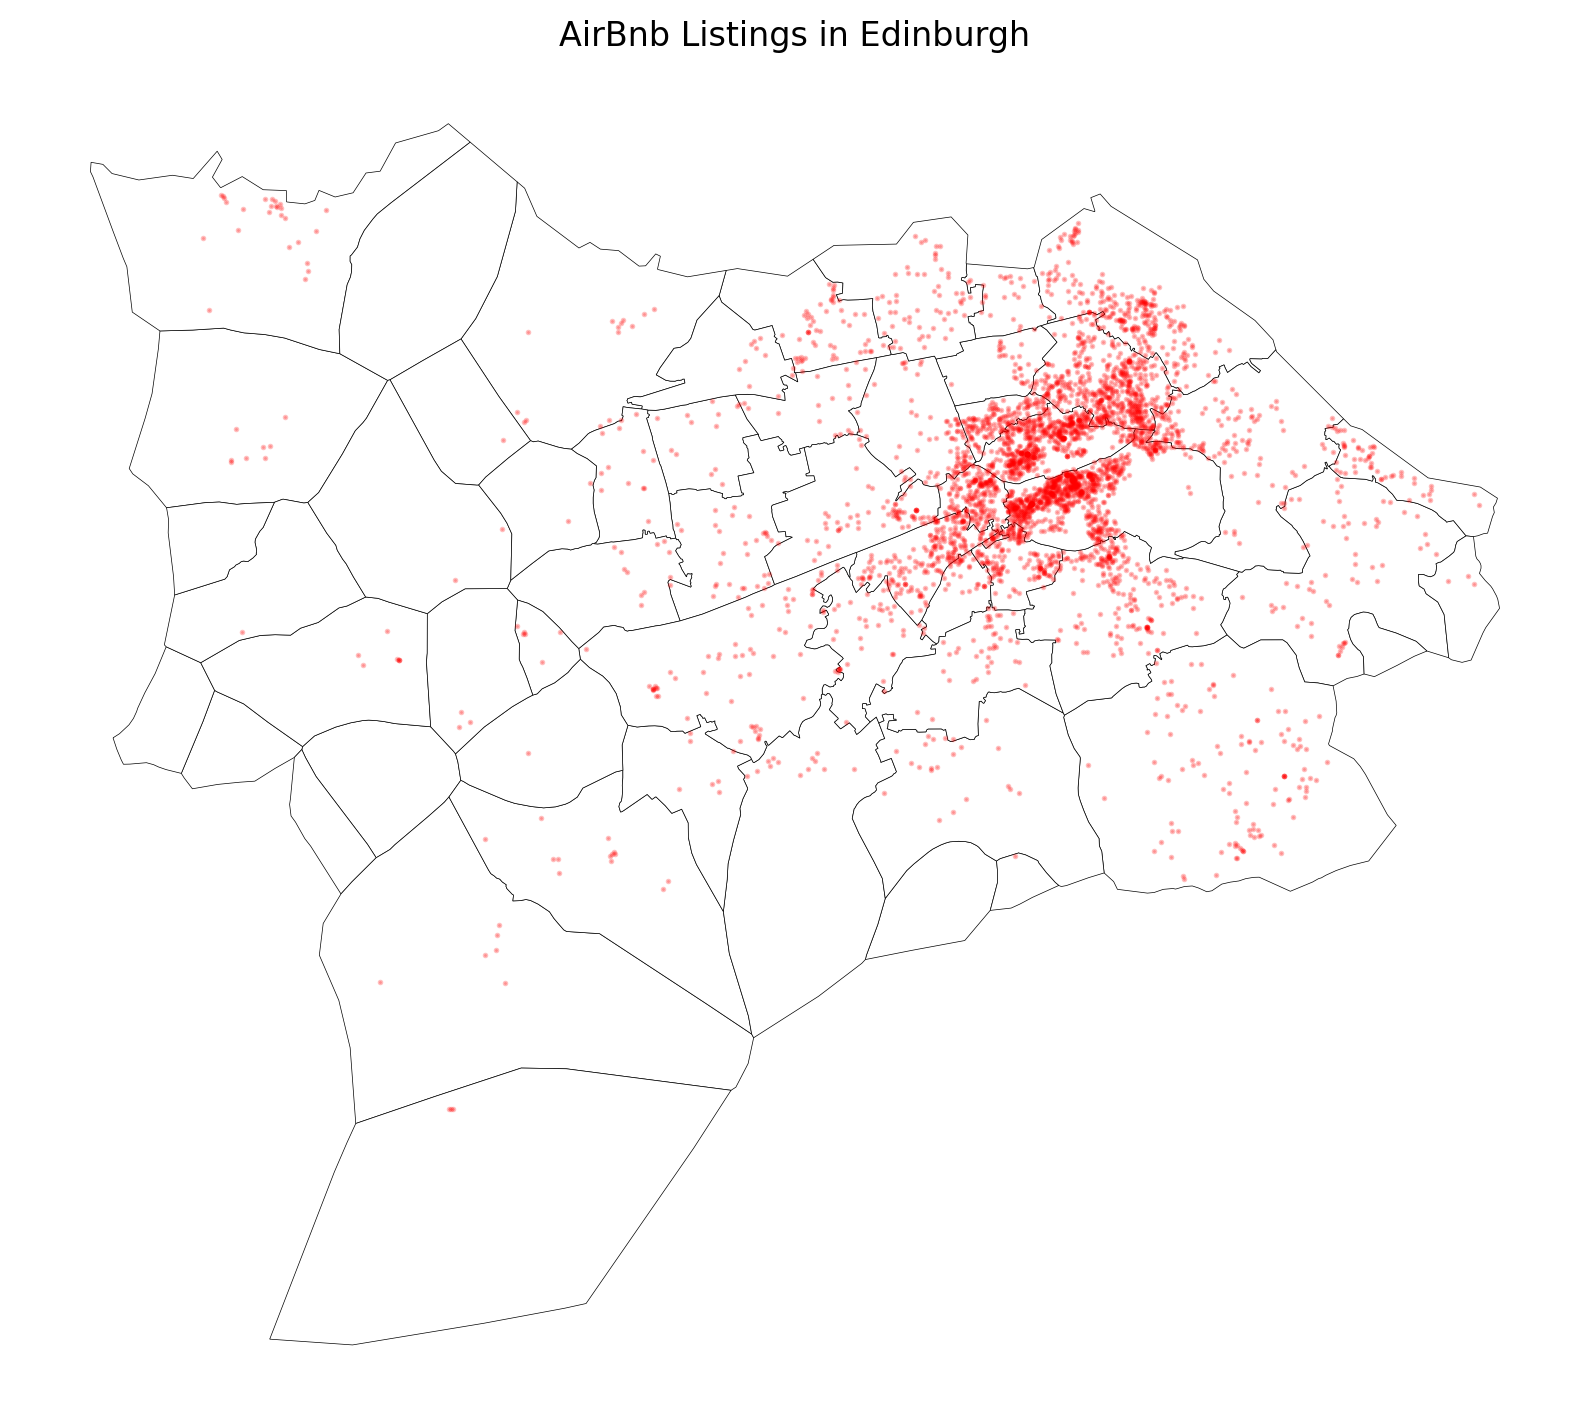

In [13]:
# Plot airbnbs
ax = edinburgh_glx.plot(figsize=(10, 10), color='white', edgecolor='black', linewidth=0.25)
# Plot the points
edinburgh_airbnb_clipped.plot(ax=ax, color = 'red', markersize=1, alpha=0.25)

ax.set_title("AirBnb Listings in Edinburgh")
ax.set_axis_off()

## 4. Feature Engineering
### Guest Volume

In [14]:
# Calculate the actual guest volume - i.e. an estimate of how many people actually stayed there in the past year
edinburgh_airbnb_clipped['estimated_guest_volume'] = (
    edinburgh_airbnb_clipped['accommodates'] *
    edinburgh_airbnb_clipped['estimated_occupancy_l365d']
)

### Variables by Town

In [15]:
# Get the number of properties in each town
edinburgh_airbnb_counts = (
    edinburgh_airbnb_clipped
    .groupby(['glx_id'])
    .size()
    .reset_index(name='property_count')
)

# Rename id column in edinburgh_glx to glx_id
edinburgh_glx = edinburgh_glx.rename(columns = {'id': 'glx_id'})

# Merge with geoms
edinburgh_glx_with_counts = edinburgh_glx.merge(
    edinburgh_airbnb_counts,
    on = "glx_id",
    how = "left"
)

# Fill NaN property counts with 0 (for LSOAs that had no listings)
edinburgh_glx_with_counts['property_count'] = edinburgh_glx_with_counts['property_count'].fillna(0).astype(int)

### Total count of listings

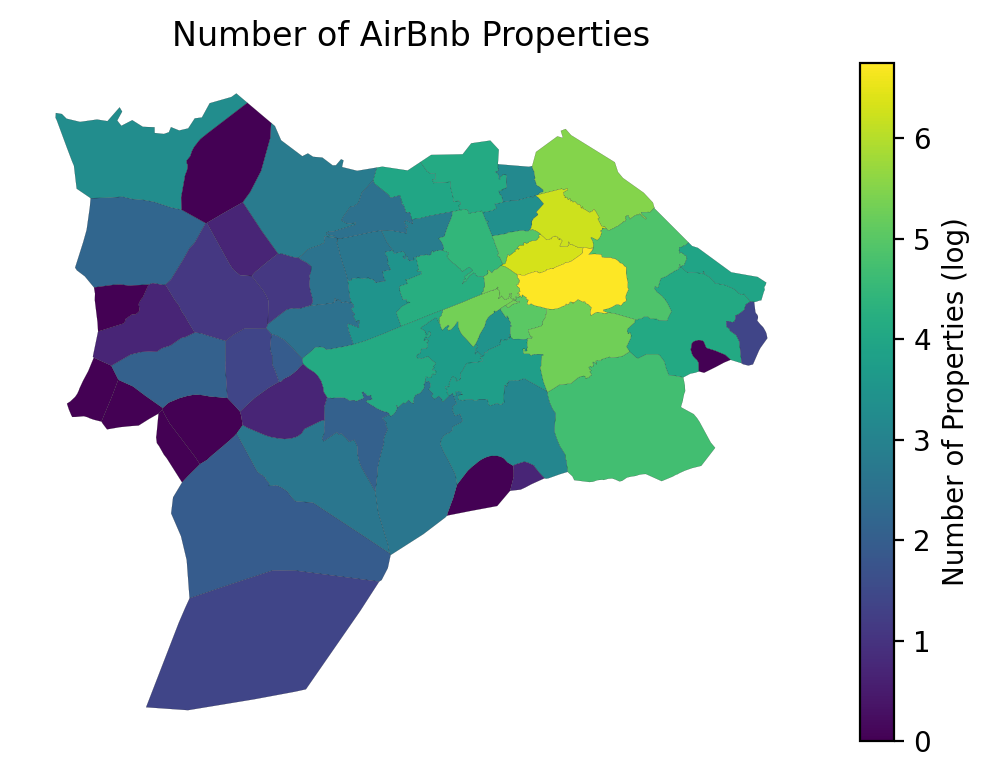

In [16]:
# Create log column
edinburgh_glx_with_counts['property_count_log'] = np.log1p(edinburgh_glx_with_counts['property_count'])

# Plot the counts
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

edinburgh_glx_with_counts.plot(
    column = 'property_count_log',
    cmap = 'viridis',
    legend = True,
    ax = ax,
    edgecolor='black',
    linewidth=0.05,
    legend_kwds={'label': "Number of Properties (log)", 'orientation': "vertical"}
)
ax.set_title("Number of AirBnb Properties", fontsize=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Density of Listings

In [17]:
# Reproject to a projected CRS
edinburgh_glx_with_density = edinburgh_glx_with_counts.to_crs(epsg=27700)

# Now calculate density correctly (properties per square meter)
edinburgh_glx_with_density['density_m2'] = edinburgh_glx_with_density['property_count'] / edinburgh_glx_with_density.geometry.area

# Per square kilometer
edinburgh_glx_with_density['density_km2'] = edinburgh_glx_with_density['density_m2'] / 1e6

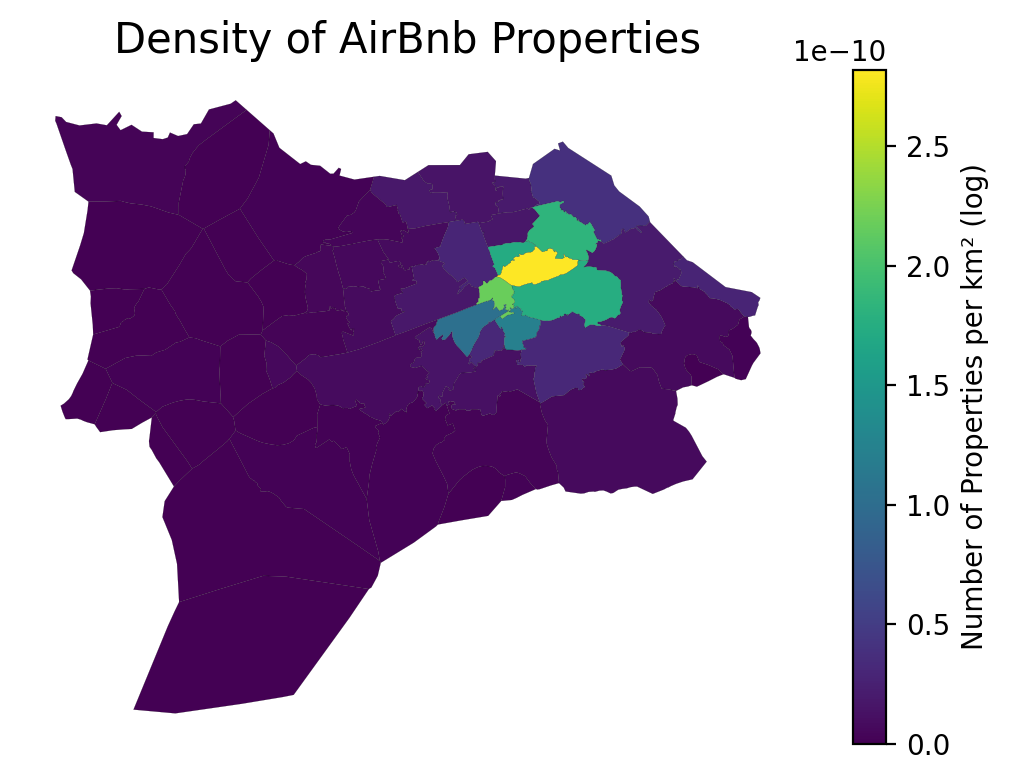

In [18]:
# Log the density
edinburgh_glx_with_density['log_density_km2'] = np.log1p(edinburgh_glx_with_density['density_km2'])

edinburgh_glx_with_density['log_density_m2'] = np.log1p(edinburgh_glx_with_density['density_m2'])

# Plot the density
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

edinburgh_glx_with_density.plot(
    column = 'density_km2',
    cmap = 'viridis',
    legend = True,
    ax = ax,
    edgecolor='black',
    linewidth=0.05,
    legend_kwds={'label': "Number of Properties per km² (log)", 'orientation': "vertical"}
)
ax.set_title("Density of AirBnb Properties", fontsize=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Model Target Variables

In [19]:
airbnb_per_edinburgh_glx = edinburgh_airbnb_clipped.groupby(['glx_id']).agg(
    num_properties = ('id', 'count'),
    total_revenue = ('estimated_revenue_l365d', 'sum'),
    total_volume = ('estimated_guest_volume', 'sum')
).reset_index()

# Round all columns to 2 decimal places
for col in airbnb_per_edinburgh_glx.columns:
    if col not in ['glx_id']:
        airbnb_per_edinburgh_glx[col] = airbnb_per_edinburgh_glx[col].round(2)

airbnb_per_edinburgh_glx = edinburgh_glx_with_counts[['glx_id', 'geometry']].merge(
    airbnb_per_edinburgh_glx,
    on = ['glx_id'],
    how = 'left'
)

# Convert to geoDataFrame
airbnb_per_edinburgh_glx = gpd.GeoDataFrame(
    airbnb_per_edinburgh_glx,
    geometry=airbnb_per_edinburgh_glx['geometry'],
    crs = "EPSG:4326"
)

# Join the density data
airbnb_per_edinburgh_glx = airbnb_per_edinburgh_glx.merge(
    edinburgh_glx_with_density[["glx_id", "density_m2", "density_km2"]],
    on = "glx_id",
    how = 'left'
)

# Create logged versions of each of the columns
airbnb_per_edinburgh_glx['num_properties_log'] = np.log1p(airbnb_per_edinburgh_glx['num_properties'])
airbnb_per_edinburgh_glx['density_m2_log'] = np.log1p(airbnb_per_edinburgh_glx['density_m2'])
airbnb_per_edinburgh_glx['density_km2_log'] = np.log1p(airbnb_per_edinburgh_glx['density_km2'])
airbnb_per_edinburgh_glx['total_revenue_log'] = np.log1p(airbnb_per_edinburgh_glx['total_revenue'])
airbnb_per_edinburgh_glx['total_volume_log'] = np.log1p(airbnb_per_edinburgh_glx['total_volume'])

In [20]:
# Set EPSG:4326 as the CRS for the GeoDataFrame
airbnb_per_edinburgh_glx.crs = "EPSG:27700"

# Calculate the tourism intensity volume / area of the town
airbnb_per_edinburgh_glx['total_tourism_intensity'] = (
    airbnb_per_edinburgh_glx['total_volume'] /
    airbnb_per_edinburgh_glx.geometry.area
)

# Per square kilometer
airbnb_per_edinburgh_glx['total_tourism_intensity_km2'] = airbnb_per_edinburgh_glx['total_tourism_intensity'] / 1e6

# Log them
airbnb_per_edinburgh_glx['total_tourism_intensity_km2_log'] = np.log1p(airbnb_per_edinburgh_glx['total_tourism_intensity_km2'])

# Remove the intensity columns that are not per km2
airbnb_per_edinburgh_glx = airbnb_per_edinburgh_glx.drop(columns=['total_tourism_intensity'])

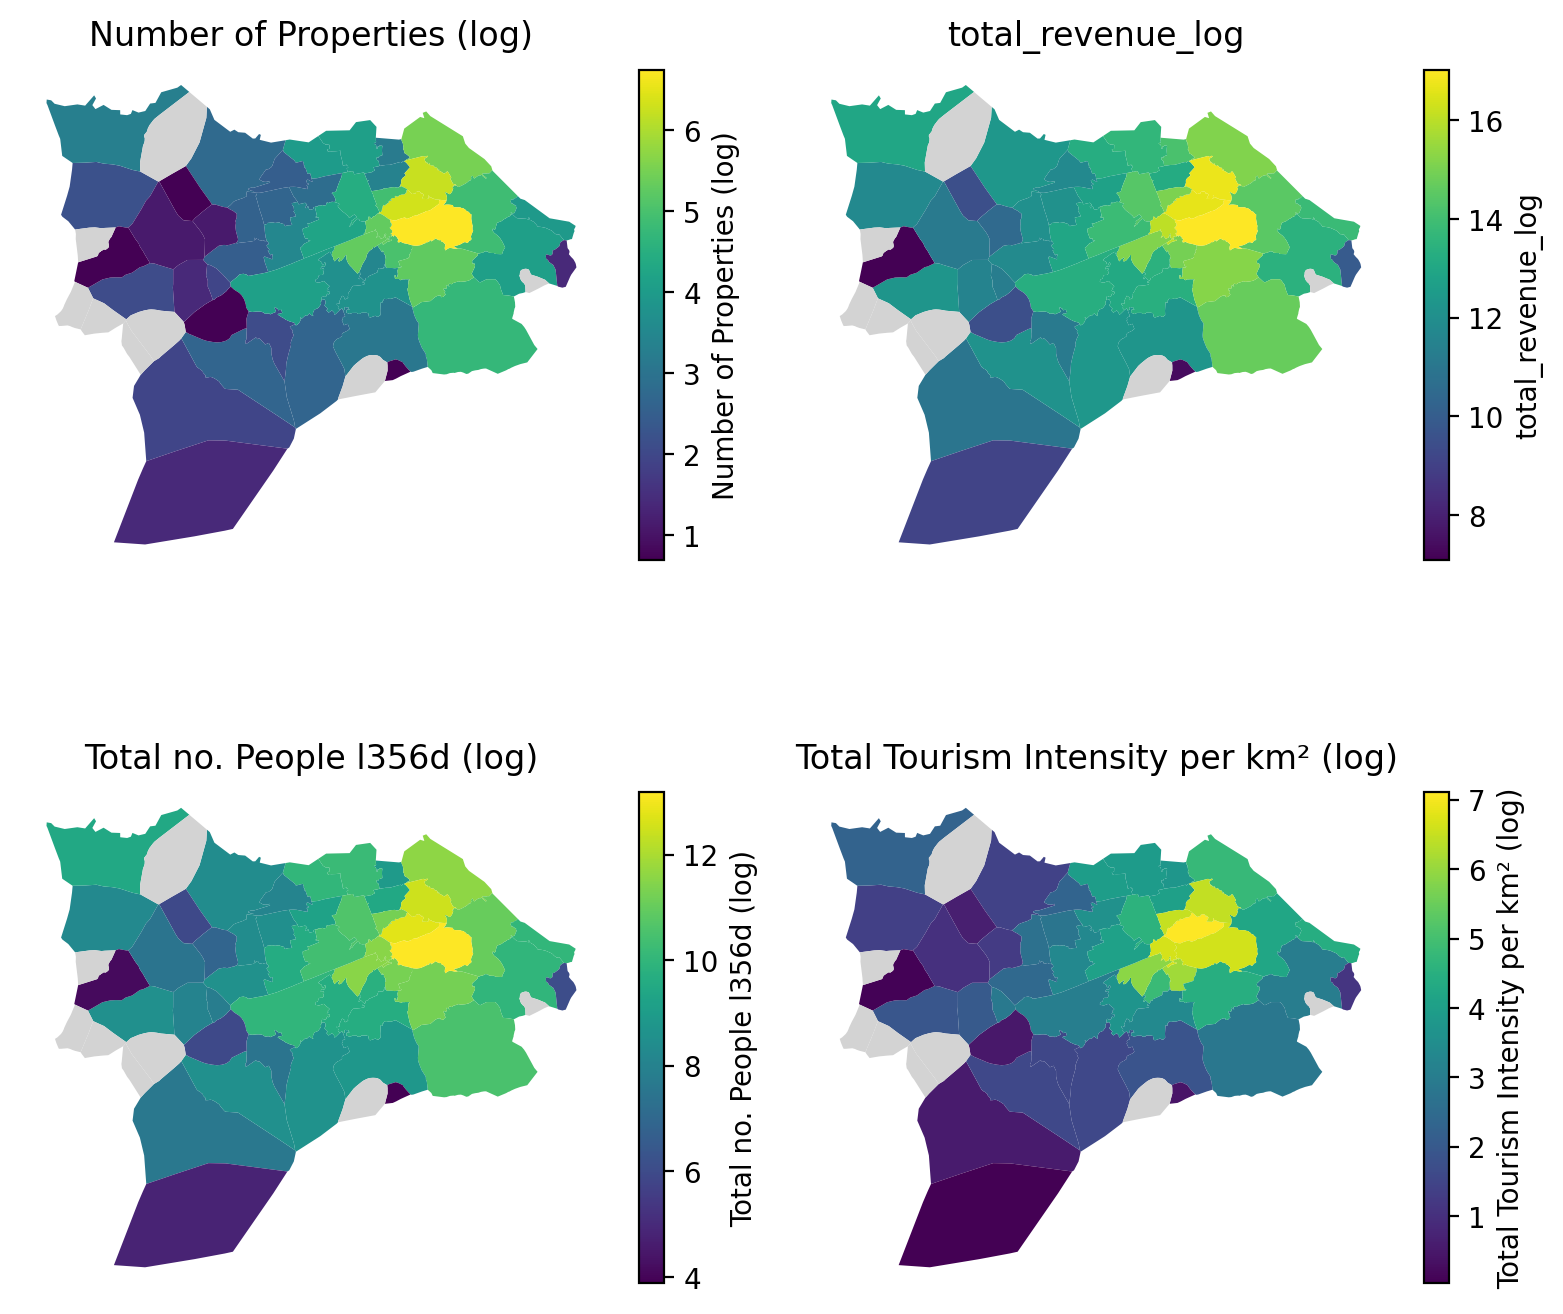

In [21]:
airbnb_plot_cols = [
    'num_properties',
    'total_revenue',
    'total_volume',
    'total_tourism_intensity_km2'
]

legend_titles = {
    'num_properties': 'Number of Properties',
    'total_volume' : 'Total no. People l356d',
    'total_tourism_intensity_km2': 'Total Tourism Intensity per km²',
}

airbnb_plot_cols_log = [
    'num_properties_log',
    'total_revenue_log',
    'total_volume_log',
    'total_tourism_intensity_km2_log'
]

legend_titles_log = {
    'num_properties_log': 'Number of Properties (log)',
    'total_volume_log' : 'Total no. People l356d (log)',
    'total_tourism_intensity_km2_log': 'Total Tourism Intensity per km² (log)',
}

airbnb_per_edinburgh_glx.crs = "EPSG:4326"

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes = axes.flatten()  # Flatten to easily loop through

for i, column in enumerate(airbnb_plot_cols_log):
    ax = axes[i]

    airbnb_per_edinburgh_glx.plot(
        column=column,
        ax=ax,
        cmap='viridis',
        legend=True,
        legend_kwds={'label': legend_titles_log.get(column, column), 'shrink': 0.6},
        missing_kwds={
            "color": "lightgrey",
            "label": "No Data"
        }
    )
    
    ax.set_title(legend_titles_log.get(column, column), fontsize=12)
    ax.axis('off')

# Turn off any unused subplots if columns < 6
for j in range(len(airbnb_plot_cols_log), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

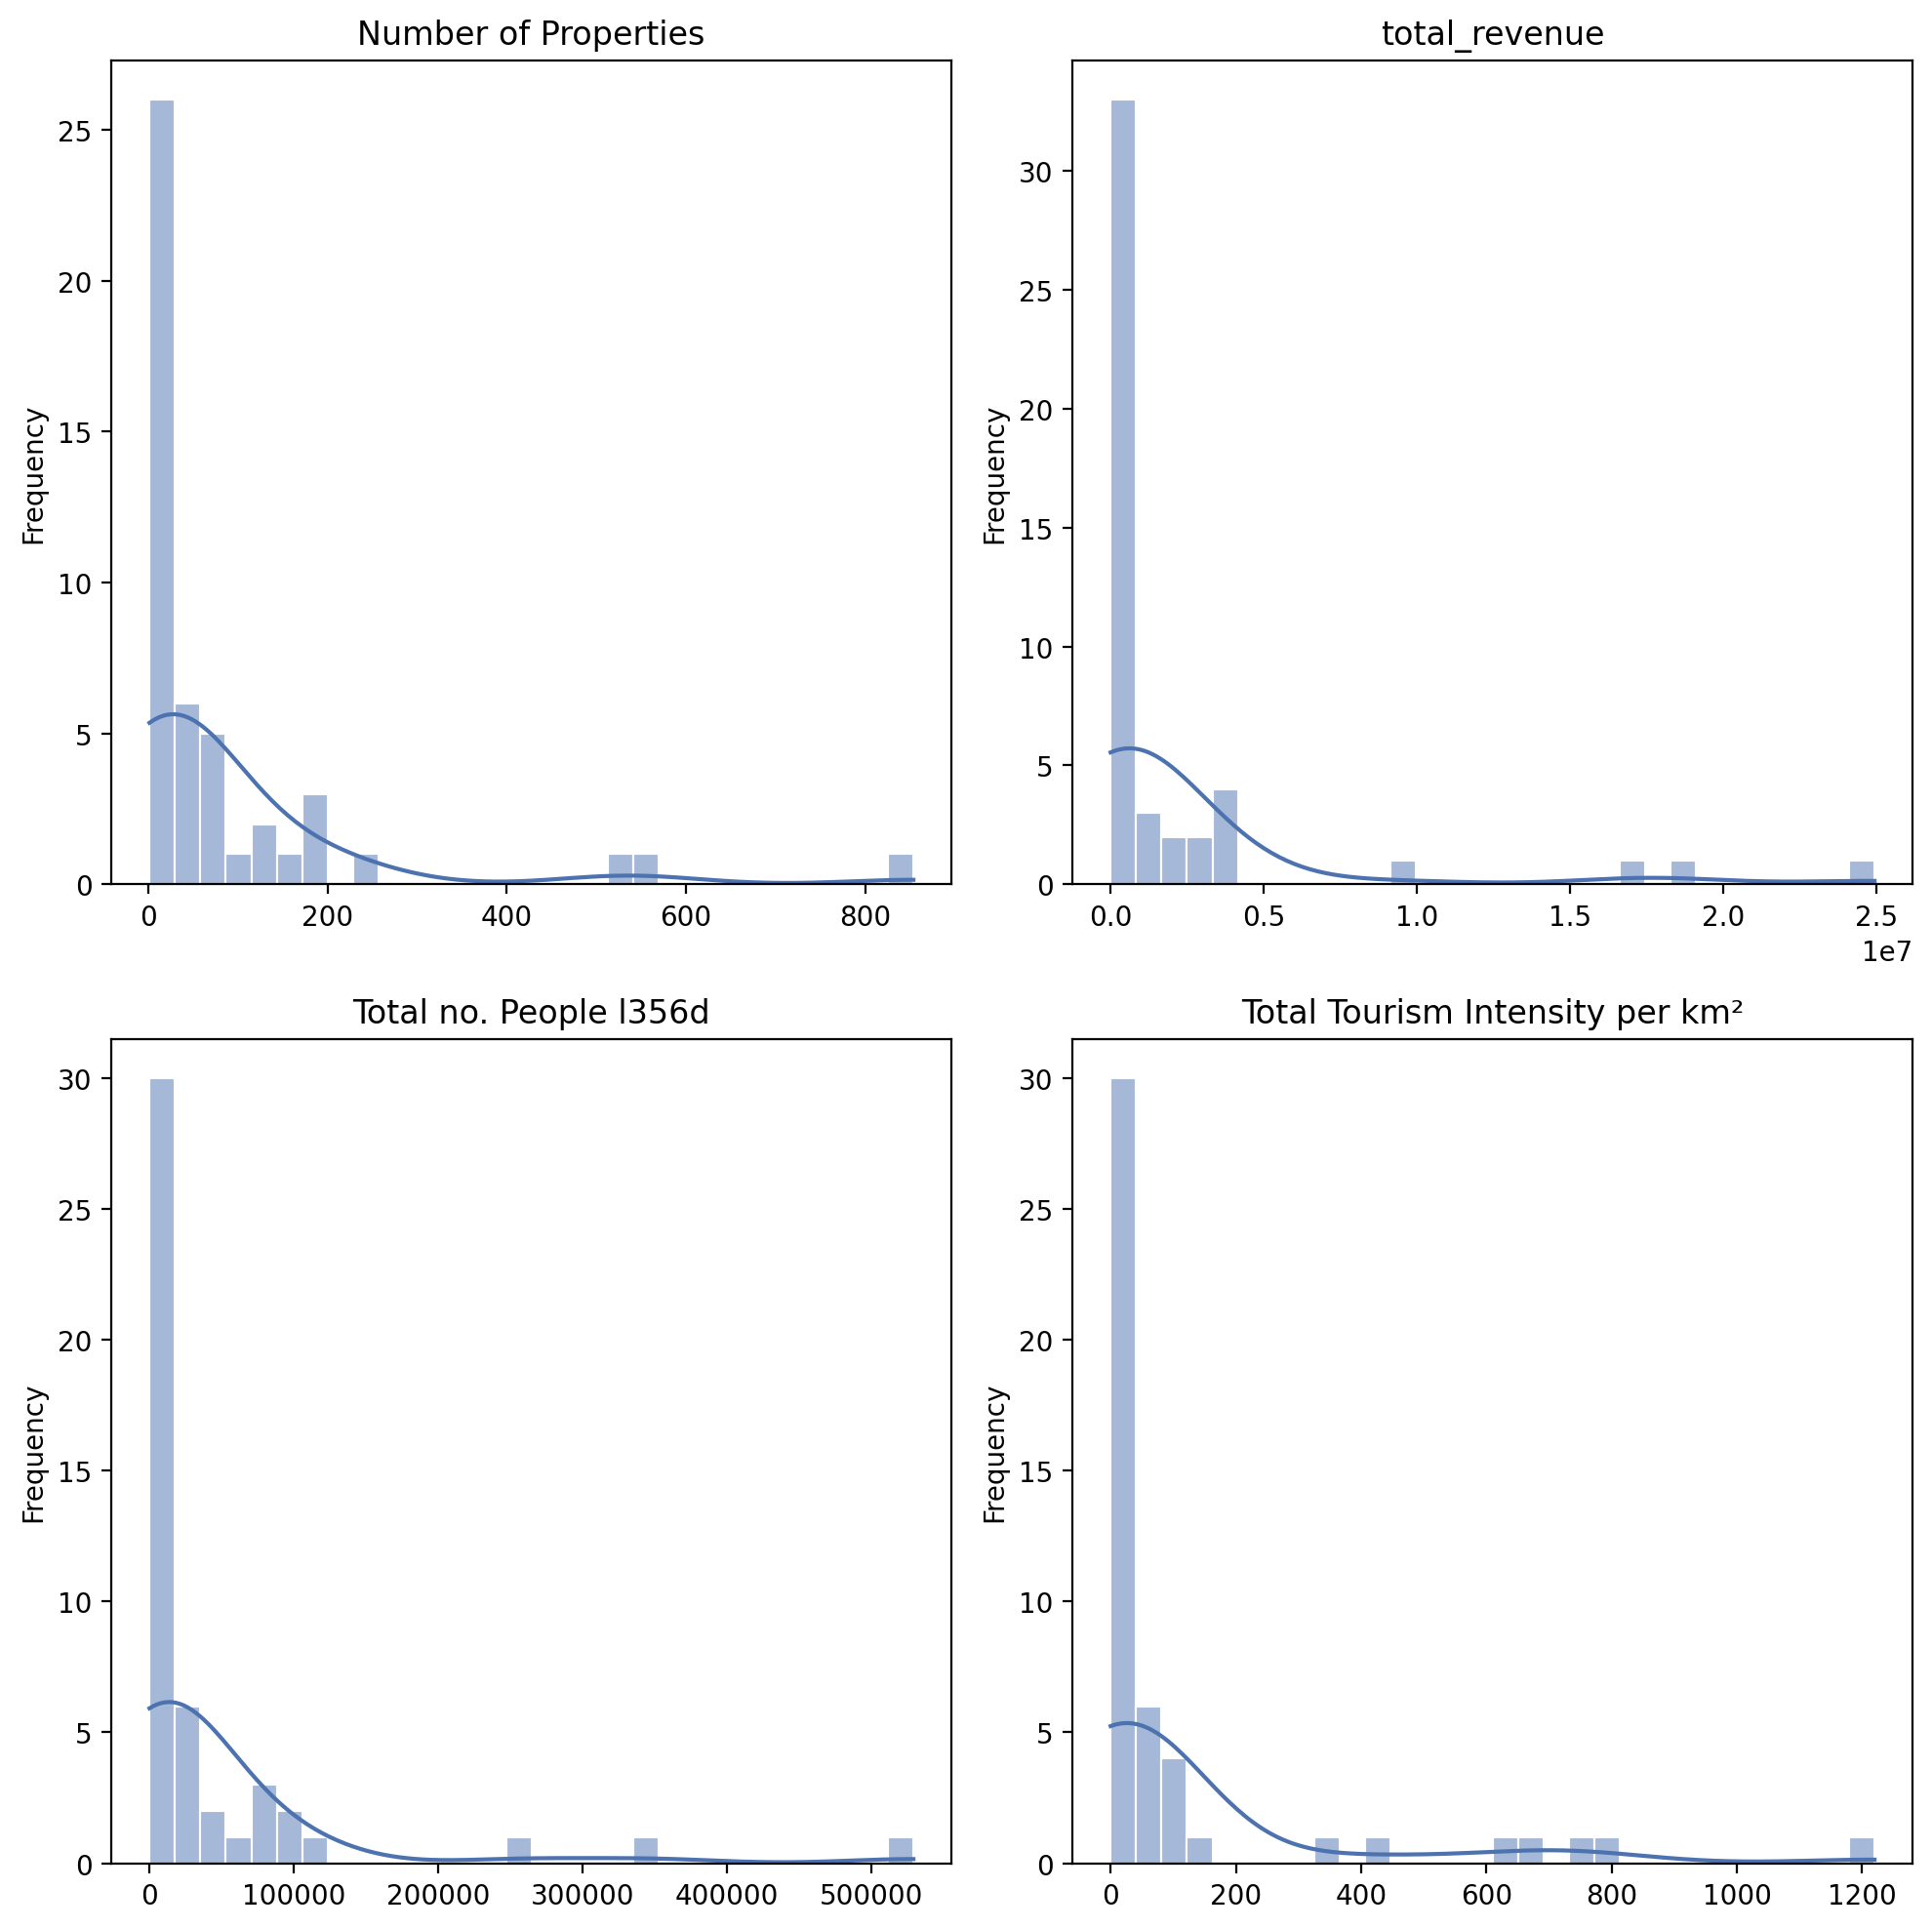

In [22]:
# Histograms of non-logged variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = axes.flatten()

for i, col in enumerate(airbnb_plot_cols):
    sns.histplot(
        data = airbnb_per_edinburgh_glx,
        x = col,
        ax = axes[i],
        kde = True,
        color = '#4c72b0',
        edgecolor = 'white',
        bins = 30
    )
    axes[i].set_title(legend_titles.get(col, col), fontsize = 12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")

# Turn off any unused subplots if columns < 6
for j in range(len(airbnb_plot_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

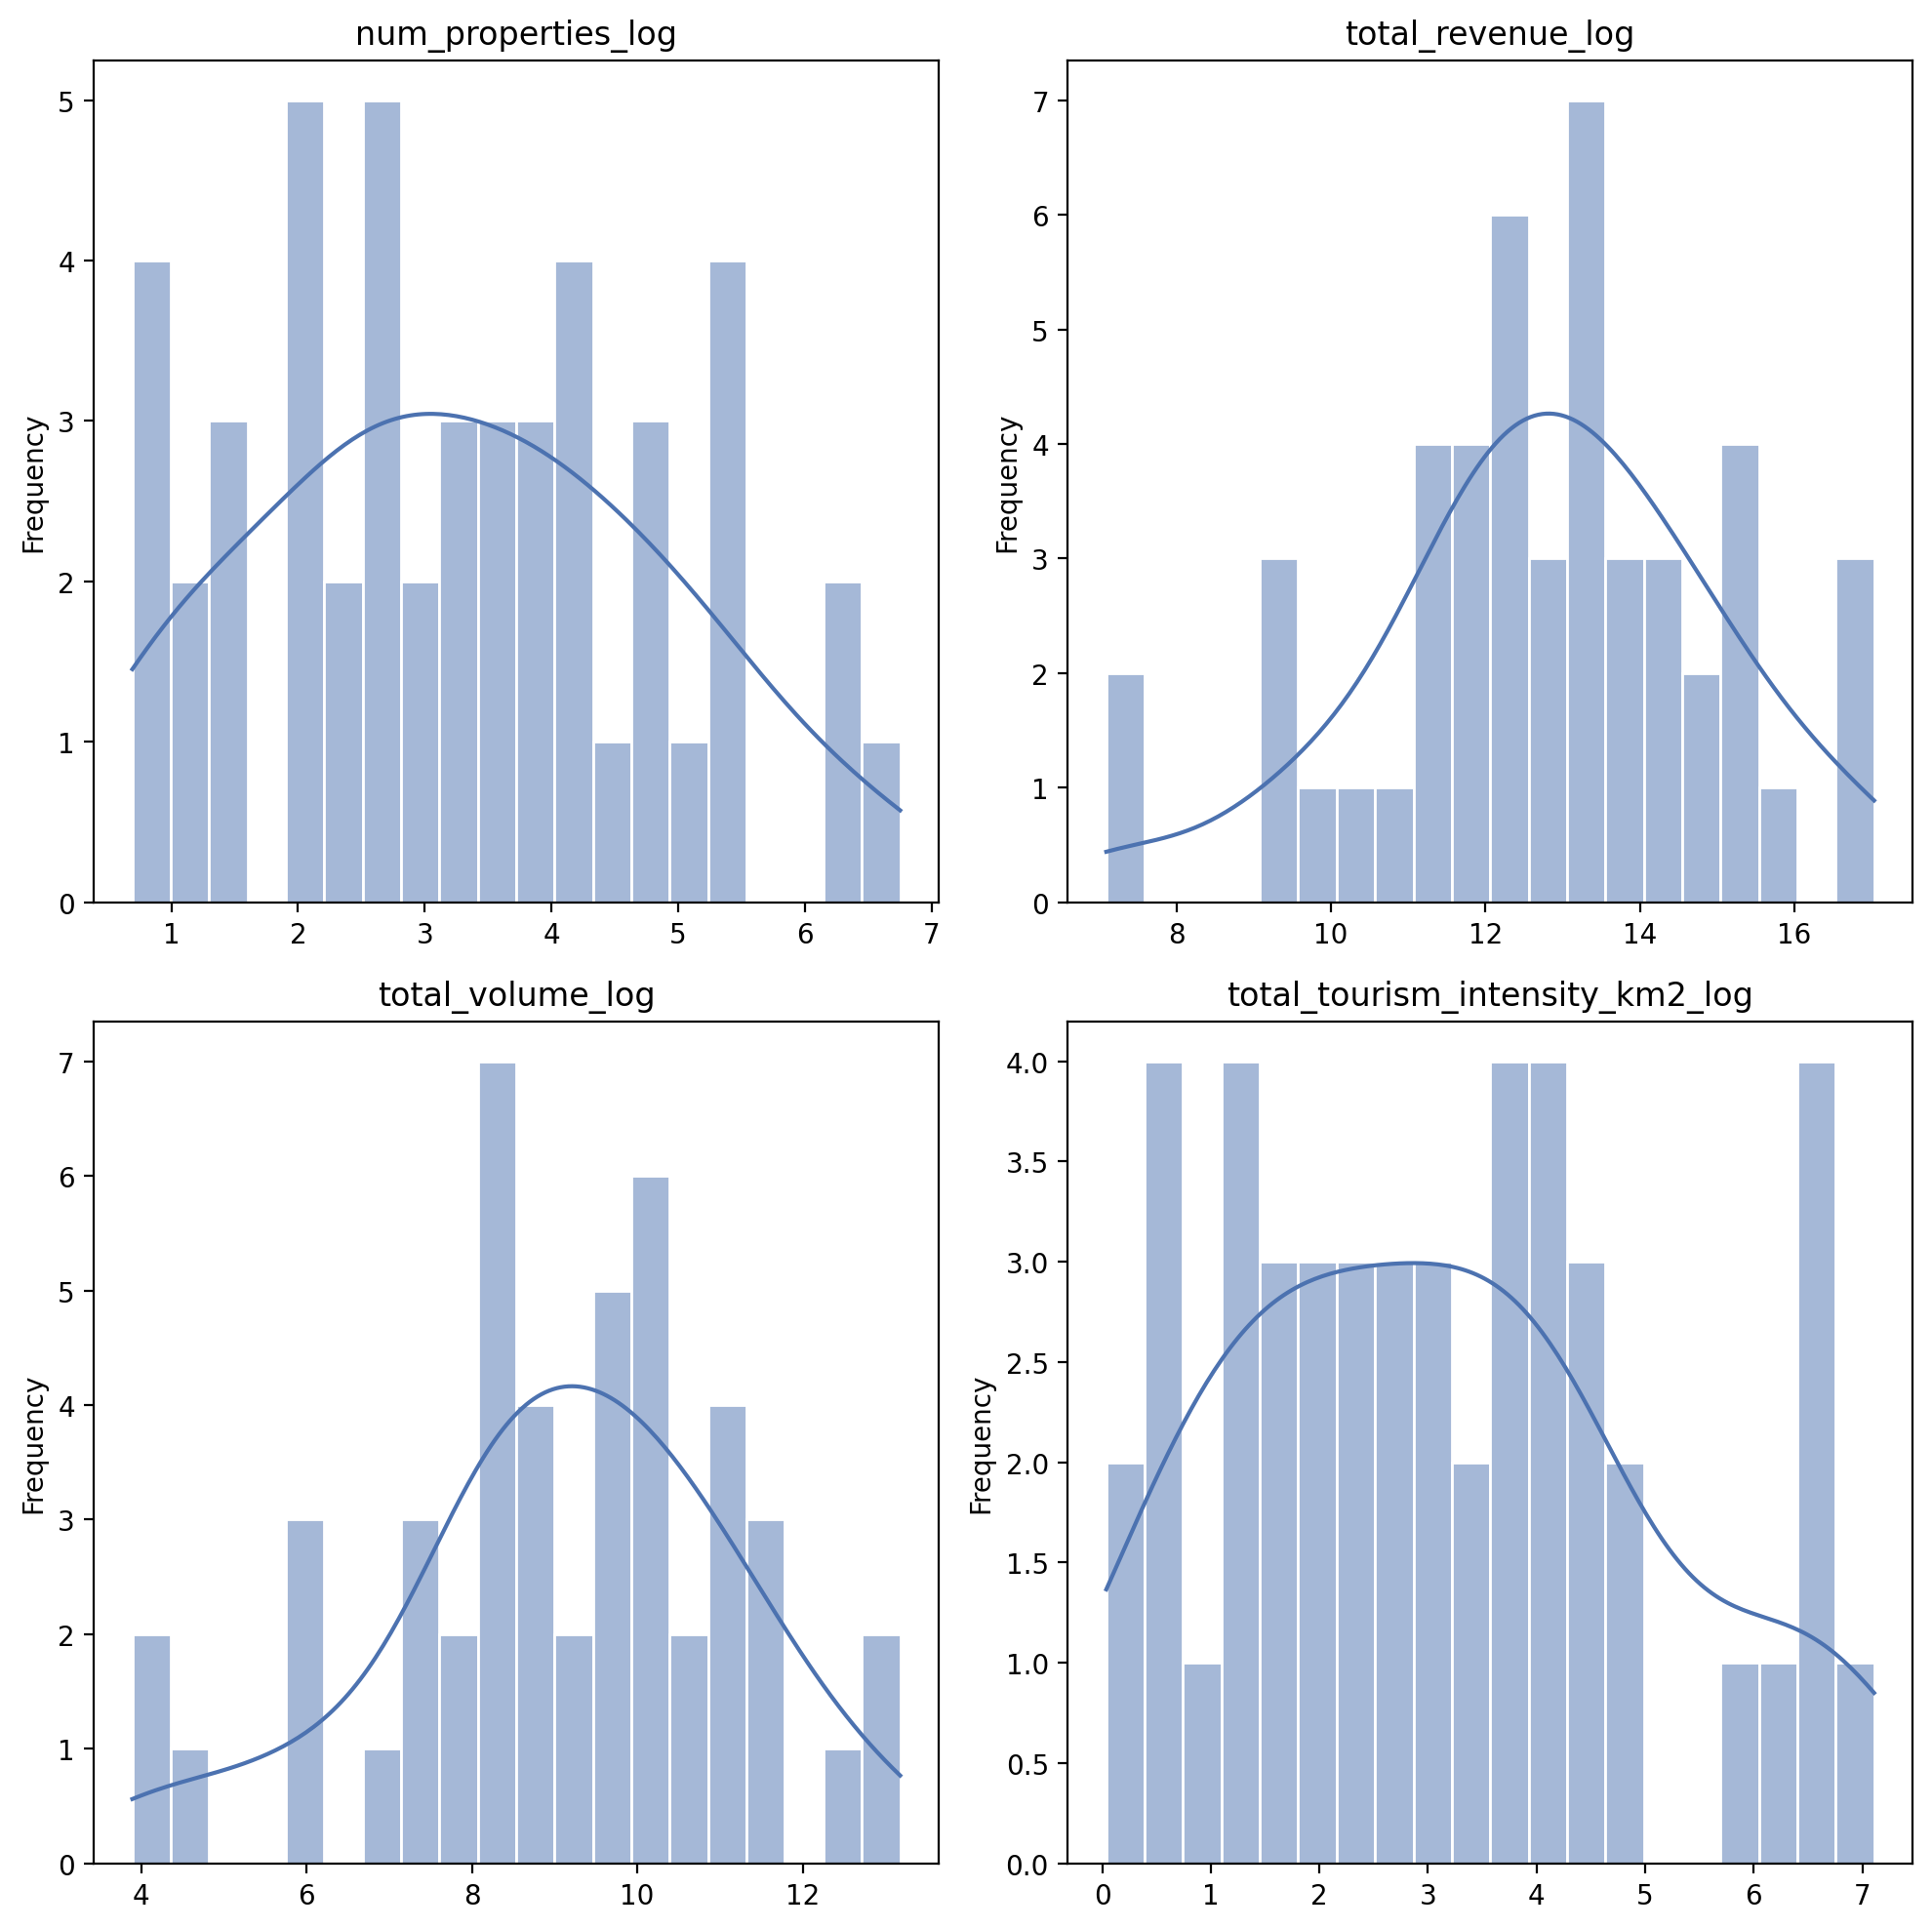

In [25]:
# Logged Histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = axes.flatten()

for i, col in enumerate(airbnb_plot_cols_log):
    sns.histplot(
        data = airbnb_per_edinburgh_glx,
        x = col,
        ax = axes[i],
        kde = True,
        color = '#4c72b0',
        edgecolor = 'white',
        bins = 20
    )
    axes[i].set_title(legend_titles.get(col, col), fontsize = 12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")

# Turn off any unused subplots if columns < 6
for j in range(len(airbnb_plot_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 5. Saved Cleaned Data

In [26]:
# Save airbnb_per_edinburgh_glx
airbnb_per_edinburgh_glx.to_file('../../data/edinburgh/airbnb_per_edinburgh_glx.gpkg', driver = "GPKG")